In [57]:
import pandas as pd

# Leer el archivo Parquet generado
df = pd.read_parquet("../data/interim/raw_concat.parquet")

# Mostrar las 5 primeras filas
df.head()


,Row Name,Clip Start,Clip End,Set_num,Set_num: Time,Set_P1,Set_P1: Time,Set_P2,Set_P2: Time,Servicio,Servicio: Time,Jugador,Jugador: Time,Pareja,Pareja: Time,Cara_pala,Cara_pala: Time,Pared,Pared: Time,Punto_lost,Punto_lost: Time,Error,Error: Time,Punto_win,Punto_win: Time,Winner,Winner: Time,Juego_win,Juego_win: Time,Juego_lost,Juego_lost: Time,Break_point,Break_point: Time,Set_point,Set_point: Time,Set_lost,Set_lost: Time,Set_win,Set_win: Time,Fuerza error,Fuerza error: Time,Match point,Match point: Time,Zona resto,Zona resto: Time,Juego_P1,Juego_P1: Time,Juego_P2,Juego_P2: Time,Break_con,Break_con: Time,Punto_P1,Punto_P1: Time,Punto_P2,Punto_P2: Time,Golpe_q,Golpe_q: Time,Zona saque,Zona saque: Time,Inicio_gople,Inicio_gople: Time,Inicio_gople: X,Inicio_gople: Y,Fin_golpe,Fin_golpe: Time,Fin_golpe: X,Fin_golpe: Y,Asistencia,Asistencia: Time,__source_file
0,Servicio Martín Di Nenno,4.007,10.082,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,5.007,Martín Di Nenno,5.007,Di Nenno - Ausburger,5.007,Derecha,6.027,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
1,Servicio Martín Di Nenno,4.007,10.082,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Federico Chingotto,6.027,Chingotto - Galán,6.027,Reves,6.862,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
2,Servicio Martín Di Nenno,4.007,10.082,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Leandro Ausburger,6.862,<NA>,<NA>,<NA>,<NA>,Pared fondo,8.158,Di Nenno - Ausburger,10.082,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
3,Set,5.007,2285.428,1º,5.007,0,5.007,0,5.007,1º Servicio Martín Di Nenno,5.007,Martín Di Nenno,5.007,Di Nenno - Ausburger,5.007,Derecha,6.027,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
4,Set,5.007,2285.428,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Federico Chingotto,6.027,Chingotto - Galán,6.027,Reves,6.862,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv


In [58]:
import pandas as pd
df_clean = pd.read_parquet("../data/interim/final_clean.parquet")
df_clean.head()


,row_name,clip_start,clip_end,set_num,set_num:_time,set_p1,set_p1:_time,set_p2,set_p2:_time,servicio,servicio:_time,jugador,jugador:_time,pareja,pareja:_time,cara_pala,cara_pala:_time,pared,pared:_time,punto_lost,punto_lost:_time,error,error:_time,punto_win,punto_win:_time,winner,winner:_time,juego_win,juego_win:_time,juego_lost,juego_lost:_time,break_point,break_point:_time,set_point,set_point:_time,set_lost,set_lost:_time,set_win,set_win:_time,fuerza_error,fuerza_error:_time,match_point,match_point:_time,zona_resto,zona_resto:_time,juego_p1,juego_p1:_time,juego_p2,juego_p2:_time,break_con,break_con:_time,punto_p1,punto_p1:_time,punto_p2,punto_p2:_time,golpe_q,golpe_q:_time,zona_saque,zona_saque:_time,inicio_gople,inicio_gople:_time,inicio_gople:_x,inicio_gople:_y,fin_golpe,fin_golpe:_time,fin_golpe:_x,fin_golpe:_y,asistencia,asistencia:_time,__source_file
0,1º Servicio,5.007,5.712,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,5.007,Martín Di Nenno,5.007,Di Nenno - Ausburger,5.007,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,5.443,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Servicio,5.007,5,5.21,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
1,1º Servicio,22.228,22.94,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,22.228,Martín Di Nenno,22.228,Di Nenno - Ausburger,22.228,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,22.857,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Servicio,22.228,3,22.228,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
2,1º Servicio,42.192,42.897,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,42.192,Martín Di Nenno,42.192,Di Nenno - Ausburger,42.192,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,42.897,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Servicio,42.192,5,42.192,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
3,1º Servicio,62.27,62.972,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,62.27,Martín Di Nenno,62.27,Di Nenno - Ausburger,62.27,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Missed,62.963,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,62.95,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Servicio,62.27,3,62.27,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
4,1º Servicio,109.583,110.287,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,109.583,Martín Di Nenno,109.583,Di Nenno - Ausburger,109.583,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,109.939,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Servicio,109.583,5,109.583,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv


In [59]:
df_filtrado = df_clean.loc[
    df_clean["row_name"] == "Punto",    # condición de filas
    ["row_name", "punto_p1", "punto_p2"]  # columnas que quieres ver
]

In [60]:
df_filtrado

,row_name,punto_p1,punto_p2
523,Punto,0,0
524,Punto,15,0
525,Punto,15,15
526,Punto,15,30
527,Punto,30,30
...,...,...,...
646,Punto,15,40
647,Punto,0,0
648,Punto,0,15
649,Punto,0,30


In [61]:
import pandas as pd

def recortar_por_marcador(df, tipo="juego", limite=1):
    """
    Devuelve el subconjunto del DataFrame hasta que se cumpla la condición de marcador,
    ordenando previamente por 'clip_start'.

    Parámetros
    ----------
    df : pd.DataFrame
        Dataset con columnas de marcador (punto_p1, juego_p1, set_p1, etc.).
    tipo : {"juego", "set"}
        Define si recortamos por juegos o por sets.
    limite : int
        Valor máximo de juegos o sets a incluir (ej. 1 -> hasta que alguno llegue a 1 juego).
    """

    df = df.copy()
    tipo = tipo.lower()

    # 🧩 1️⃣ Asegurar orden cronológico por 'clip_start'
    if "clip_start" not in df.columns:
        raise KeyError("El DataFrame no contiene la columna 'clip_start' necesaria para ordenar.")
    df = df.sort_values("clip_start", ascending=True).reset_index(drop=True)

    # 🧩 2️⃣ Seleccionar columnas según el tipo de marcador
    if tipo == "juego":
        col_p1, col_p2 = "juego_p1", "juego_p2"
    elif tipo == "set":
        col_p1, col_p2 = "set_p1", "set_p2"
    else:
        raise ValueError("El parámetro 'tipo' debe ser 'juego' o 'set'")

    # 🧩 3️⃣ Verificar existencia de columnas
    if col_p1 not in df.columns or col_p2 not in df.columns:
        raise KeyError(f"No se encuentran las columnas {col_p1} / {col_p2} en el DataFrame.")

    # 🧩 4️⃣ Convertir a numéricos (por si vienen como texto o con nulos)
    df[col_p1] = pd.to_numeric(df[col_p1], errors="coerce").fillna(0).astype(int)
    df[col_p2] = pd.to_numeric(df[col_p2], errors="coerce").fillna(0).astype(int)

    # 🧩 5️⃣ Calcular condición de corte
    condicion = (df[col_p1] >= limite) | (df[col_p2] >= limite)

    # 🧩 6️⃣ Localizar la primera fila donde se cumple
    if condicion.any():
        idx_fin = condicion.idxmax()  # primer índice donde True
        subset = df.loc[:idx_fin].reset_index(drop=True)
    else:
        subset = df.copy()

    return subset
df_recortado = recortar_por_marcador(df_clean, tipo="juego", limite=1)

In [66]:
df_recortado

,row_name,clip_start,clip_end,set_num,set_num:_time,set_p1,set_p1:_time,set_p2,set_p2:_time,servicio,servicio:_time,jugador,jugador:_time,pareja,pareja:_time,cara_pala,cara_pala:_time,pared,pared:_time,punto_lost,punto_lost:_time,error,error:_time,punto_win,punto_win:_time,winner,winner:_time,juego_win,juego_win:_time,juego_lost,juego_lost:_time,break_point,break_point:_time,set_point,set_point:_time,set_lost,set_lost:_time,set_win,set_win:_time,fuerza_error,fuerza_error:_time,match_point,match_point:_time,zona_resto,zona_resto:_time,juego_p1,juego_p1:_time,juego_p2,juego_p2:_time,break_con,break_con:_time,punto_p1,punto_p1:_time,punto_p2,punto_p2:_time,golpe_q,golpe_q:_time,zona_saque,zona_saque:_time,inicio_gople,inicio_gople:_time,inicio_gople:_x,inicio_gople:_y,fin_golpe,fin_golpe:_time,fin_golpe:_x,fin_golpe:_y,asistencia,asistencia:_time,__source_file
0,Servicio Martín Di Nenno,4.007,10.082,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,5.007,Martín Di Nenno,5.007,Di Nenno - Ausburger,5.007,Derecha,6.027,Pared fondo,8.158,Di Nenno - Ausburger,10.082,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
1,1º Servicio,5.007,5.712,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,5.007,Martín Di Nenno,5.007,Di Nenno - Ausburger,5.007,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,5.443,0,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Servicio,5.007,5,5.21,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
2,Set,5.007,2285.428,1º,5.007,0,5.007,0,5.007,1º Servicio Martín Di Nenno,5.007,Martín Di Nenno,5.007,Di Nenno - Ausburger,5.007,Derecha,6.027,Pared fondo,8.158,Di Nenno - Ausburger,10.082,Error no forzado,23.448,Di Nenno - Ausburger,24.39,Winner,85.307,Di Nenno - Ausburger,296.263,Di Nenno - Ausburger,504.664,Break point,1007.337,Set point,2271.417,Chingotto - Galán,2285.428,Di Nenno - Ausburger,2285.428,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
3,Juego,5.007,296.263,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,5.007,Martín Di Nenno,5.007,Di Nenno - Ausburger,5.007,Derecha,6.027,Pared fondo,8.158,Di Nenno - Ausburger,10.082,Error no forzado,23.448,Di Nenno - Ausburger,24.39,Winner,85.307,Di Nenno - Ausburger,296.263,Chingotto - Galán,296.263,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,5.007,0,5.007,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
4,Punto,5.007,10.082,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,5.007,Martín Di Nenno,5.007,Di Nenno - Ausburger,5.007,Derecha,6.027,Pared fondo,8.158,Di Nenno - Ausburger,10.082,<NA>,<NA>,Chingotto - Galán,10.082,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,<NA>,0,<NA>,<NA>,<NA>,0,5.007,0,5.007,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Madrid_Cuartos_chingalan_formato.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,Punto,293.573,296.263,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Martín Di Nenno,293.573,Martín Di Nenno,293.573,Di Nenno - Ausburger,293.573,Derecha,294.913,Pared fondo,294.913,Chingotto - Galán,296.263,<NA>,<NA>,Di Nenno - Ausburger,296.263,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<N

##Intento para clasificación de golpes en un intervalo de tiempo concreto

In [69]:
df = df_recortado

In [74]:
df.to_excel("../data/processed/recortado_juego_1.xlsx", index=False)

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

def top_golpes_por_jugador_detallado(
    df,
    jugador_col="jugador",
    golpe_col="golpe_q",
    error_col="error",
    top_n=5,
    min_eventos_jugador=1,
    devolver_tabla=True,
    pintar=True
):
    d = df.copy()

    # --- Normalización ---
    for c in [jugador_col, golpe_col, error_col]:
        if c in d.columns:
            d[c] = d[c].astype("string").str.strip().str.lower()
    d = d[d[golpe_col].notna()]

    # --- Clasificar evento ---
    d["categoria"] = "bola dentro"
    d.loc[d[error_col].str.contains("error no forzado", na=False), "categoria"] = "error no forzado"
    d.loc[d[error_col].str.contains("missed", na=False), "categoria"] = "missed"

    # --- Conteo jugador × golpe × categoría ---
    conteo = (
        d.groupby([jugador_col, golpe_col, "categoria"])
         .size()
         .reset_index(name="conteo")
    )

    # Pivot para que cada categoría sea una columna
    tabla = conteo.pivot(index=[jugador_col, golpe_col], columns="categoria", values="conteo").fillna(0)
    tabla["total"] = tabla.sum(axis=1)
    tabla = tabla.reset_index()

    # --- Filtrar top-N por jugador ---
    topn = (
        tabla.sort_values(["jugador", "total"], ascending=[True, False])
             .groupby(jugador_col)
             .head(top_n)
             .reset_index(drop=True)
    )

    # --- Calcular % por golpe ---
    for col in ["bola dentro", "error no forzado", "missed"]:
        if col in topn.columns:
            topn[f"{col}_%"] = (topn[col] / topn["total"] * 100).round(1)

    # --- Calcular % global de acierto (bola dentro) por jugador ---
    aciertos_globales = (
        tabla.groupby(jugador_col)["bola dentro"].sum() / tabla.groupby(jugador_col)["total"].sum() * 100
    ).round(1)

    # --- Pintar ---
    if pintar:
        for jug, g in topn.groupby(jugador_col):
            g = g.sort_values("total", ascending=True)

            # gráfico stacked
            plt.figure(figsize=(8, 4))
            plt.barh(g[golpe_col], g["bola dentro"], color="#4caf50", label="Bola dentro")
            plt.barh(g[golpe_col], g["error no forzado"], left=g["bola dentro"], color="#ff9800", label="Error no forzado")
            plt.barh(g[golpe_col], g["missed"], left=g["bola dentro"] + g["error no forzado"], color="#f44336", label="Missed")

            # Etiquetas de totales
            for i, total in enumerate(g["total"]):
                plt.text(total + 0.3, i, f"{int(total)}", va="center", fontsize=9)

            plt.title(f"Top {top_n} golpes — {jug} (Acierto: {aciertos_globales[jug]}%)")
            plt.xlabel("Número de golpes")
            plt.ylabel("Tipo de golpe")
            plt.legend(title="Categoría", loc="lower right")
            plt.tight_layout()
            plt.show()

    if devolver_tabla:
        return topn.sort_values(["jugador", "total"], ascending=[True, False])


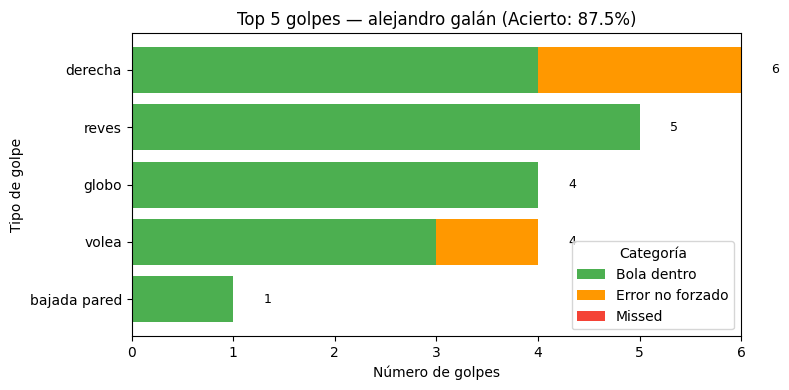

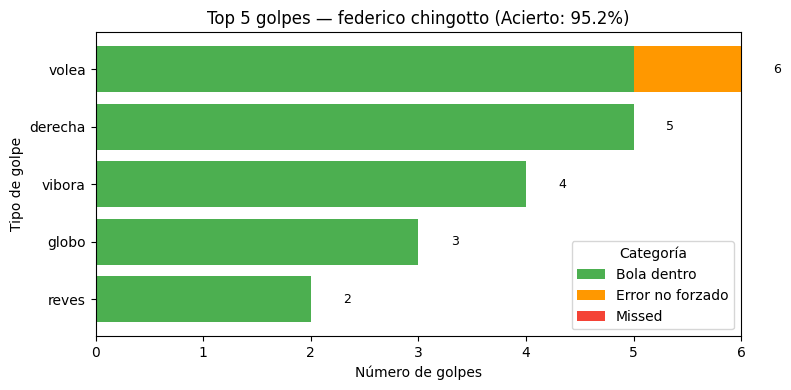

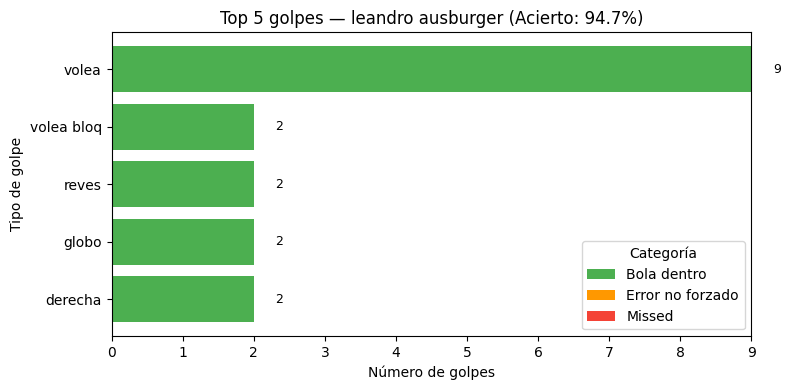

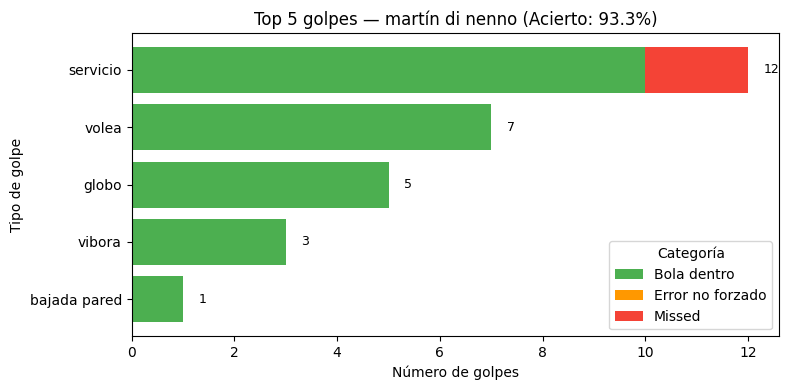

categoria,jugador,golpe_q,bola dentro,error no forzado,missed,total,bola dentro_%,error no forzado_%,missed_%
0,alejandro galán,derecha,4.0,2.0,0.0,6.0,66.7,33.3,0.0
1,alejandro galán,reves,5.0,0.0,0.0,5.0,100.0,0.0,0.0
2,alejandro galán,globo,4.0,0.0,0.0,4.0,100.0,0.0,0.0
3,alejandro galán,volea,3.0,1.0,0.0,4.0,75.0,25.0,0.0
4,alejandro galán,bajada pared,1.0,0.0,0.0,1.0,100.0,0.0,0.0
5,federico chingotto,volea,5.0,1.0,0.0,6.0,83.3,16.7,0.0
6,federico chingotto,derecha,5.0,0.0,0.0,5.0,100.0,0.0,0.0
7,federico chingotto,vibora,4.0,0.0,0.0,4.0,100.0,0.0,0.0
8,federico chingotto,globo,3.0,0.0,0.0,3.0,100.0,0.0,0.0
9,federico chingotto,reves,2.0,0.0,0.0,2.0,100.0,0.0,0.0


In [86]:
top5_tabla = top_golpes_por_jugador_detallado(df, jugador_col="jugador", golpe_col="golpe_q", error_col="error", top_n=5)
display(top5_tabla)


⚠️ No hay datos válidos para martín di nenno. Revisa coordenadas.


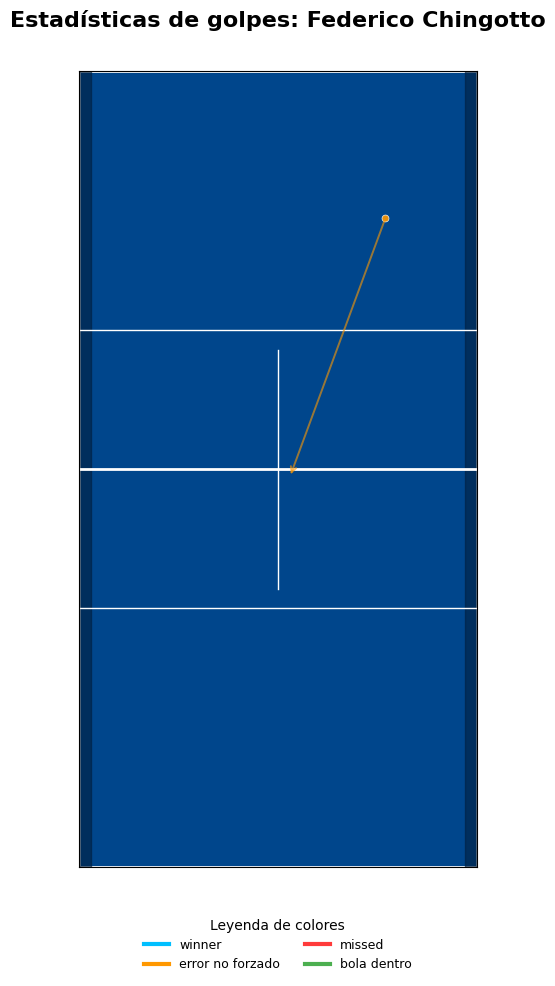

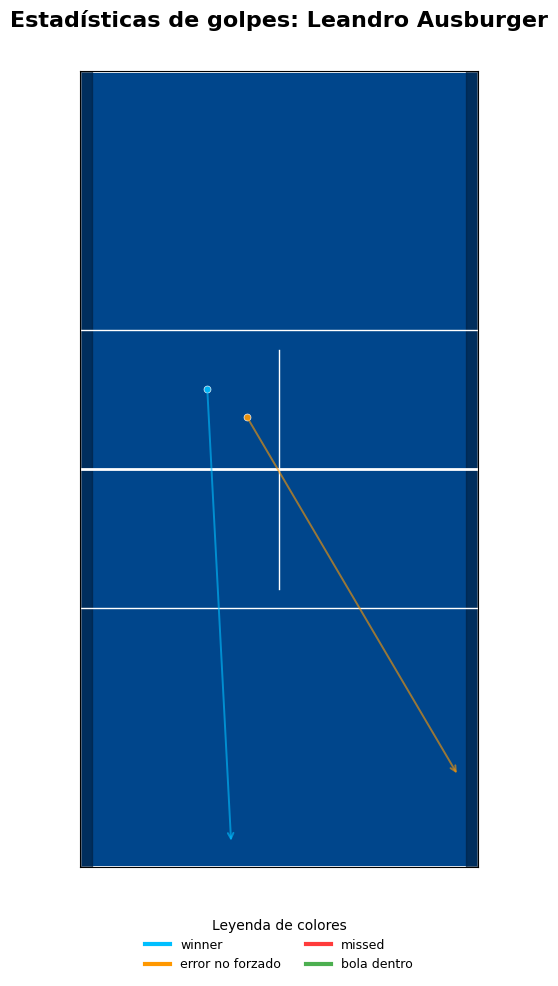

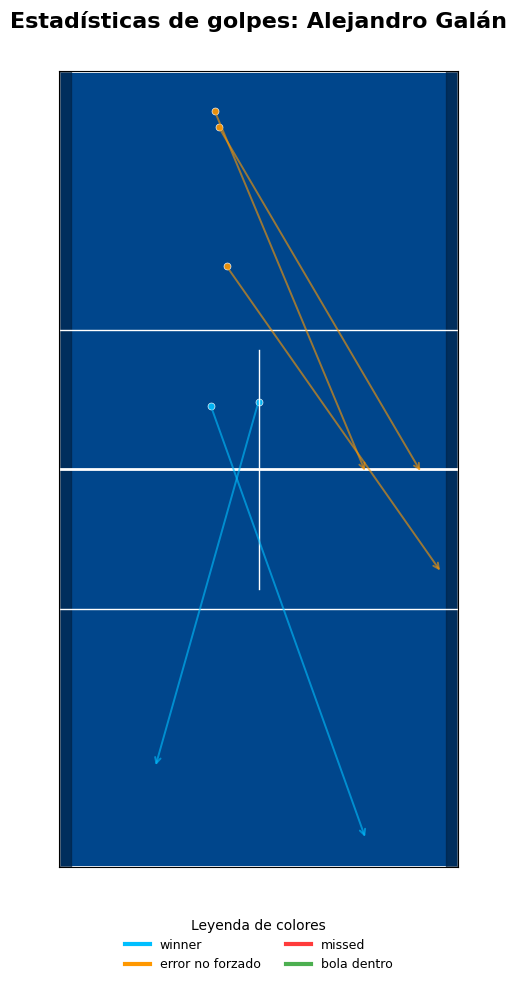

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ======================================================
# CONFIGURACIÓN
# ======================================================

ANCHO_PISTA = 100
LARGO_PISTA = 200

COL_JUGADOR  = "jugador"
COL_WINNER   = "winner"
COL_ERROR    = "error"
COL_INICIO_X = "inicio_gople:_x"
COL_INICIO_Y = "inicio_gople:_y"
COL_FIN_X    = "fin_golpe:_x"
COL_FIN_Y    = "fin_golpe:_y"

COLORES_EVENTO = {
    "winner": "#00BFFF",           # Azul brillante
    "error no forzado": "#FF9800", # Naranja
    "missed": "#FF3B3B",           # Rojo
    "bola dentro": "#4CAF50"       # Verde
}


# ======================================================
# CLASIFICAR EVENTOS
# ======================================================

def clasificar_eventos(df: pd.DataFrame) -> pd.DataFrame:
    df[COL_WINNER] = df[COL_WINNER].astype(str).str.lower().str.strip()
    df[COL_ERROR]  = df[COL_ERROR].astype(str).str.lower().str.strip()

    df["categoria"] = "bola dentro"
    df.loc[df[COL_ERROR].str.contains("error no forzado", na=False), "categoria"] = "error no forzado"
    df.loc[df[COL_ERROR].str.contains("missed", na=False), "categoria"] = "missed"
    df.loc[df[COL_WINNER].str.contains("winner", na=False), "categoria"] = "winner"

    return df


# ======================================================
# DIBUJAR LA PISTA
# ======================================================

def dibujar_pista(ax):
    """Dibuja una pista azul profesional sin texto ni líneas discontinuas."""
    ax.set_xlim(0, ANCHO_PISTA)
    ax.set_ylim(0, LARGO_PISTA)
    ax.set_aspect("equal")
    ax.set_facecolor("#003C77")

    # Fondo con gradiente leve
    for alpha in np.linspace(0.02, 0.15, 8):
        circ = patches.Circle((50, 100), radius=100 + alpha*400,
                              color="#0055A4", alpha=alpha)
        ax.add_patch(circ)

    # Contorno y líneas sólidas
    ax.add_patch(patches.Rectangle((0, 0), 100, 200, linewidth=2,
                                   edgecolor="white", facecolor="none"))

    ax.axhline(y=100, color="white", linewidth=2)   # red
    ax.axhline(y=65, color="white", linewidth=1)    # línea servicio propia
    ax.axhline(y=135, color="white", linewidth=1)   # línea servicio rival
    ax.axvline(x=50, ymin=0.35, ymax=0.65, color="white", linewidth=1)

    # Paredes laterales
    ax.add_patch(patches.Rectangle((0, 0), 3, 200, color="#001F3F", alpha=0.6))
    ax.add_patch(patches.Rectangle((97, 0), 3, 200, color="#001F3F", alpha=0.6))

    # Config ejes
    ax.set_xticks([]); ax.set_yticks([])
    ax.tick_params(colors="white")
    # 🔹 NO invertimos el eje Y: tu campo abajo, rival arriba
    # (En matplotlib el 0 está abajo por defecto)


# ======================================================
# FUNCIÓN PRINCIPAL DE PINTADO
# ======================================================

def pintar_golpes_por_jugador(df: pd.DataFrame):
    jugadores = df[COL_JUGADOR].dropna().unique()

    for jugador in jugadores:
        dfj = df[df[COL_JUGADOR] == jugador].dropna(
            subset=[COL_INICIO_X, COL_INICIO_Y, COL_FIN_X, COL_FIN_Y]
        )

        if dfj.empty:
            print(f"⚠️ No hay datos válidos para {jugador}. Revisa coordenadas.")
            continue

        fig, ax = plt.subplots(figsize=(6, 10))
        dibujar_pista(ax)

        # 🔹 Título principal
        fig.suptitle(f"Estadísticas de golpes: {jugador.title()}",
                     color="black", fontsize=16, fontweight="bold")

        # 🔹 Dibujar golpes (inicio → fin con flecha)
        for _, row in dfj.iterrows():
            cat = row["categoria"]
            color = COLORES_EVENTO.get(cat, "gray")

            # Flecha de dirección del golpe
            ax.annotate("",
                xy=(row[COL_FIN_X], row[COL_FIN_Y]),
                xytext=(row[COL_INICIO_X], row[COL_INICIO_Y]),
                arrowprops=dict(arrowstyle="->", color=color,
                                lw=1.4, alpha=0.7)
            )

            # Punto de inicio
            ax.scatter(row[COL_INICIO_X], row[COL_INICIO_Y],
                       color=color, s=25, edgecolor="white",
                       linewidth=0.5, alpha=0.9)

        # 🔹 Leyenda (texto negro y explicativo)
        handles = [
            plt.Line2D([0], [0], color=c, lw=3, label=lbl)
            for lbl, c in COLORES_EVENTO.items()
        ]
        labels = [
            "🟩 Bola dentro (pelota en juego)",
            "🟦 Winner (punto ganado)",
            "🟧 Error no forzado (fallo propio)",
            "🟥 Missed (fallo forzado o arriesgado)"
        ]
        # Reordenar manualmente para la explicación
        handles_ordered = [handles[3], handles[0], handles[1], handles[2]]

        ax.legend(handles=handles_ordered, labels=labels,
                  loc="upper center", bbox_to_anchor=(0.5, -0.05),
                  ncol=1, frameon=False, fontsize=9, labelcolor="black")

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()


# ======================================================
# EJECUCIÓN
# ======================================================

df = clasificar_eventos(df)
pintar_golpes_por_jugador(df)
